<a href="https://colab.research.google.com/github/aziz122596/Gentex/blob/main/new_method_ovarian_cancer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [2]:
# Загрузка двух CSV файлов
disease_data = pd.read_csv('/content/merged_datasets.xlsx - disease (1).csv')
health_data = pd.read_csv('/content/merged_datasets.xlsx - health (1).csv')

In [3]:
# Step 2:
def preprocess_data(disease_data, health_data):
    combined_data = pd.concat([disease_data, health_data], axis=0)

    combined_data = combined_data.drop(columns=["Accession"], errors="ignore")

    combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)

    imputer = SimpleImputer(strategy="mean")
    combined_data_imputed = imputer.fit_transform(combined_data)

    scaler = MinMaxScaler()
    combined_data_normalized = scaler.fit_transform(combined_data_imputed)

    return combined_data_normalized

processed_data = preprocess_data(disease_data, health_data)

<ipython-input-3-e3a7f9f21211>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['BENIGN_1' 'BENIGN_2' 'BENIGN_3' 'BENIGN_5' 'BENIGN_7' 'BENIGN_8'
 'MALIGNANT_2' 'MALIGNANT_4' 'MALIGNANT_5' 'MALIGNANT_6' 'MALIGNANT_7'
 'MALIGNANT_8' 'HGSOC_SA01' 'HGSOC_SA02' 'HGSOC_SA04' 'HGSOC_SA05'
 'HGSOC_SA06' 'HGSOC_SA09' 'HGSOC_SA10' 'HGSOC_SA11' 'HGSOC_SA15'
 'HGSOC_SA16' 'HGSOC_SC01' 'HGSOC_SC02' 'HGSOC_SC04' 'HGSOC_SC06'
 'HGSOC_SC08' 'HGSOC_SC10' 'HGSOC_SC15' 'HGSOC_SC16' 'HGSOC_SC17'
 'HGSOC_SC22' 'HGSOC_SC24' 'HGSOC_SC27' 'HGSOC_SC28' 'HGSOC_SC30'
 'HGS

In [4]:
# Step 3:
X_train, X_test = train_test_split(processed_data, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [5]:
# Step 4:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar


In [6]:
# Step 5:
def loss_function(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.MSELoss()(reconstructed, original)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

input_dim = X_train.shape[1]
latent_dim = 16
vae = VAE(input_dim, latent_dim)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
batch_size = 64
epochs = 10

train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch_data, _ in train_loader:
        optimizer.zero_grad()
        reconstructed, mu, logvar = vae(batch_data)
        loss = loss_function(reconstructed, batch_data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/10, Loss: 0.7670
Epoch 2/10, Loss: 0.0023
Epoch 3/10, Loss: 0.0011
Epoch 4/10, Loss: 0.0009
Epoch 5/10, Loss: 0.0010
Epoch 6/10, Loss: 0.0014
Epoch 7/10, Loss: 0.0028
Epoch 8/10, Loss: 0.0014
Epoch 9/10, Loss: 0.0009
Epoch 10/10, Loss: 0.0008


In [7]:
# Step 6:
vae.eval()
with torch.no_grad():
    reconstructed, _, _ = vae(X_test_tensor)
    test_loss = loss_function(reconstructed, X_test_tensor, _, _).item()
print(f"Test Loss: {test_loss:.4f}")

torch.save(vae.state_dict(), "/content/megred/vae_model.pth")

print("Model training complete and saved. Ready for further tasks.")

Test Loss: 0.0157
Model training complete and saved. Ready for further tasks.


In [8]:
# vae.eval()
# with torch.no_grad():
#     reconstructed, _, _ = vae(X_test_tensor)
#     test_loss = loss_function(reconstructed, X_test_tensor, _, _).item()
#     print(f"Test Loss: {test_loss:.4f}")
vae.eval()
with torch.no_grad():
    train_mu, _ = torch.chunk(vae.encoder(X_train_tensor), 2, dim=1)
    test_mu, _ = torch.chunk(vae.encoder(X_test_tensor), 2, dim=1)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


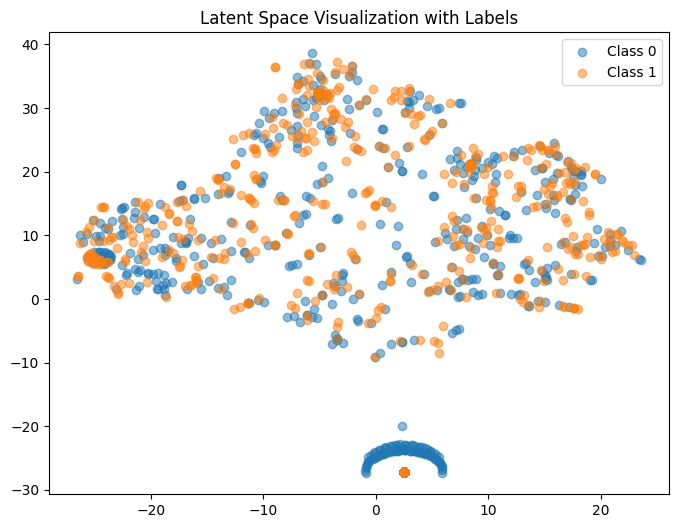

In [9]:
train_labels = np.array([0] * (train_mu.size(0) // 2) + [1] * (train_mu.size(0) - train_mu.size(0) // 2))
test_labels = np.array([0] * (test_mu.size(0) // 2) + [1] * (test_mu.size(0) - test_mu.size(0) // 2))

clf = LogisticRegression()
clf.fit(train_mu.numpy(), train_labels)

test_predictions = clf.predict(test_mu.numpy())
accuracy = accuracy_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

latent_2d = TSNE(n_components=2, random_state=42).fit_transform(test_mu.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[test_labels == 0, 0], latent_2d[test_labels == 0, 1], label="Class 0", alpha=0.5)
plt.scatter(latent_2d[test_labels == 1, 0], latent_2d[test_labels == 1, 1], label="Class 1", alpha=0.5)
plt.title("Latent Space Visualization with Labels")
plt.legend()
plt.show()



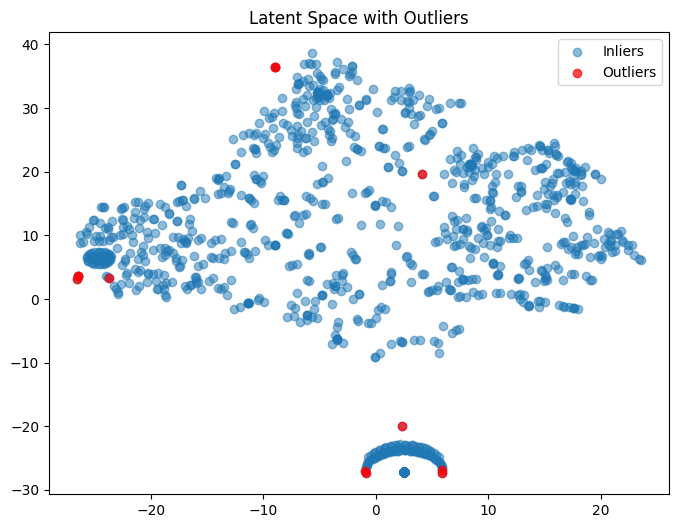

{'Accuracy': 0.49967721110393803,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1 Score': 0.0}

In [10]:
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(latent_2d)
outliers = latent_2d[outlier_labels == -1]

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], label="Inliers", alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], label="Outliers", color="red", alpha=0.7)
plt.title("Latent Space with Outliers")
plt.legend()
plt.show()

classification_metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}

classification_metrics

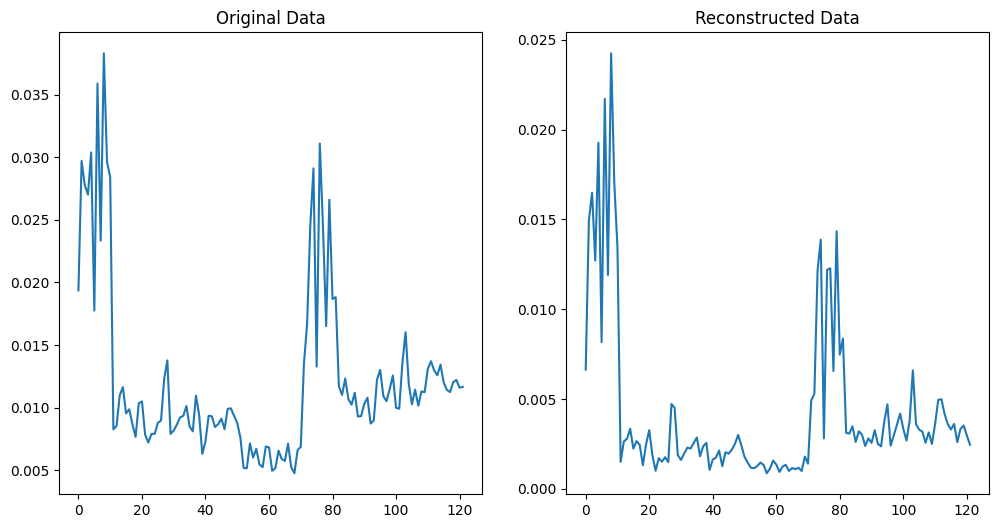

In [11]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, X_test_tensor.size(0))
original = X_test_tensor[idx].numpy()
reconstruction = reconstructed[idx].numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Data")
plt.plot(original)
plt.subplot(1, 2, 2)
plt.title("Reconstructed Data")
plt.plot(reconstruction)
plt.show()


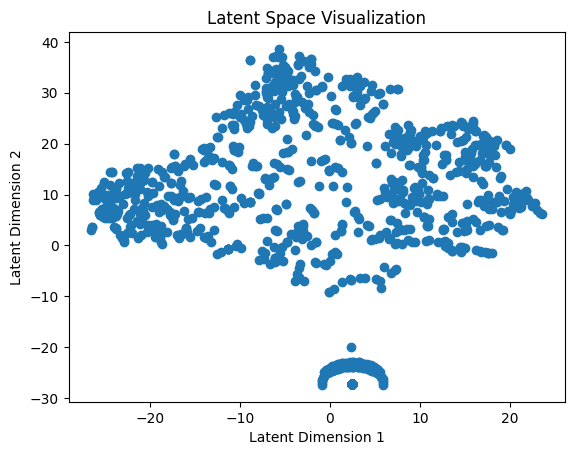

In [12]:
from sklearn.manifold import TSNE

with torch.no_grad():
    mu, _ = torch.chunk(vae.encoder(X_test_tensor), 2, dim=1)
latent_features = mu.numpy()

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

plt.scatter(latent_2d[:, 0], latent_2d[:, 1])
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


In [13]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load Data
# Load disease and health data
disease_data = pd.read_csv('/content/merged_datasets.xlsx - disease (1).csv')
health_data = pd.read_csv('/content/merged_datasets.xlsx - health (1).csv')

# Step 2: Data Preprocessing
def preprocess_data(disease_data, health_data):
    # Combine datasets
    combined_data = pd.concat([disease_data, health_data], axis=0)

    # Drop the "Accession" column as it is an identifier
    combined_data = combined_data.drop(columns=["Accession"], errors="ignore")

    # Replace non-numeric values and commas with NaN
    combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)

    # Impute missing values with column mean
    imputer = SimpleImputer(strategy="mean")
    combined_data_imputed = imputer.fit_transform(combined_data)

    # Normalize data
    scaler = MinMaxScaler()
    combined_data_normalized = scaler.fit_transform(combined_data_imputed)

    return combined_data_normalized

# Preprocess the data
processed_data = preprocess_data(disease_data, health_data)

# Step 3: Generate Synthetic Data
def generate_synthetic_data(existing_data, num_samples=100):
    """
    Generates synthetic data based on the mean and standard deviation
    of existing data columns.

    Args:
        existing_data (numpy.ndarray): Original data to base generation on.
        num_samples (int): Number of synthetic samples to generate.

    Returns:
        synthetic_data (numpy.ndarray): Generated synthetic data.
    """
    # Calculate mean and standard deviation for each feature
    feature_means = np.mean(existing_data, axis=0)
    feature_stds = np.std(existing_data, axis=0)

    # Generate synthetic data using normal distribution
    synthetic_data = np.random.normal(loc=feature_means, scale=feature_stds, size=(num_samples, existing_data.shape[1]))

    # Clip values to stay within the original data range
    min_values = np.min(existing_data, axis=0)
    max_values = np.max(existing_data, axis=0)
    synthetic_data = np.clip(synthetic_data, min_values, max_values)

    return synthetic_data

# Generate synthetic data based on preprocessed original data
synthetic_samples = 200  # Number of synthetic samples to generate
synthetic_data = generate_synthetic_data(processed_data, num_samples=synthetic_samples)

# Step 4: Save the Generated Data
synthetic_data_df = pd.DataFrame(synthetic_data, columns=[f"Feature_{i+1}" for i in range(synthetic_data.shape[1])])
synthetic_data_df.to_csv("synthetic_data_based_on_existing.csv", index=False)

print(f"Synthetic data generated and saved to 'synthetic_data_based_on_existing.csv' ({synthetic_samples} samples).")


Synthetic data generated and saved to 'synthetic_data_based_on_existing.csv' (200 samples).


<ipython-input-13-56e2a6f3c9e8>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data = combined_data.replace(r'[^0-9.-]', np.nan, regex=True).astype(float)
/usr/local/lib/python3.10/dist-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['BENIGN_1' 'BENIGN_2' 'BENIGN_3' 'BENIGN_5' 'BENIGN_7' 'BENIGN_8'
 'MALIGNANT_2' 'MALIGNANT_4' 'MALIGNANT_5' 'MALIGNANT_6' 'MALIGNANT_7'
 'MALIGNANT_8' 'HGSOC_SA01' 'HGSOC_SA02' 'HGSOC_SA04' 'HGSOC_SA05'
 'HGSOC_SA06' 'HGSOC_SA09' 'HGSOC_SA10' 'HGSOC_SA11' 'HGSOC_SA15'
 'HGSOC_SA16' 'HGSOC_SC01' 'HGSOC_SC02' 'HGSOC_SC04' 'HGSOC_SC06'
 'HGSOC_SC08' 'HGSOC_SC10' 'HGSOC_SC15' 'HGSOC_SC16' 'HGSOC_SC17'
 'HGSOC_SC22' 'HGSOC_SC24' 'HGSOC_SC27' 'HGSOC_SC28' 'HGSOC_SC30'
 'H

Synthetic data predictions saved to 'synthetic_data_predictions.csv'.
Predictions completed. Evaluate them based on manual analysis or specific objectives.


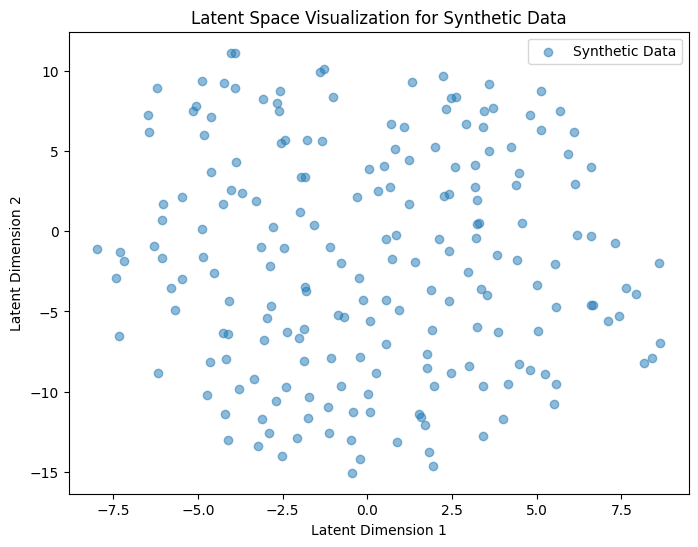

In [14]:
# Step 1: Preprocess synthetic data
synthetic_data_tensor = torch.tensor(synthetic_data, dtype=torch.float32)

# Step 2: Apply the trained VAE to synthetic data
vae.eval()
with torch.no_grad():
    reconstructed, mu, logvar = vae(synthetic_data_tensor)

# Step 3: Predict class labels using the trained classifier
synthetic_predictions = clf.predict(mu.numpy())

# Step 4: Save results to a file
# Combine synthetic data and predictions for analysis
synthetic_results = pd.DataFrame(synthetic_data, columns=[f"Feature_{i+1}" for i in range(synthetic_data.shape[1])])
synthetic_results["Prediction"] = synthetic_predictions
synthetic_results.to_csv("/content/synthetic_data_based_on_existing.csv", index=False)

print("Synthetic data predictions saved to 'synthetic_data_predictions.csv'.")

# Step 5: Evaluate metrics on synthetic data
# Note: Since synthetic data doesn't have true labels, this is primarily for testing model functionality.
# If you have true labels, compare them to predictions.
print("Predictions completed. Evaluate them based on manual analysis or specific objectives.")

# Step 6: Visualize latent space for synthetic data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_2d = TSNE(n_components=2, random_state=42).fit_transform(mu.numpy())

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], label="Synthetic Data", alpha=0.5)
plt.title("Latent Space Visualization for Synthetic Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()


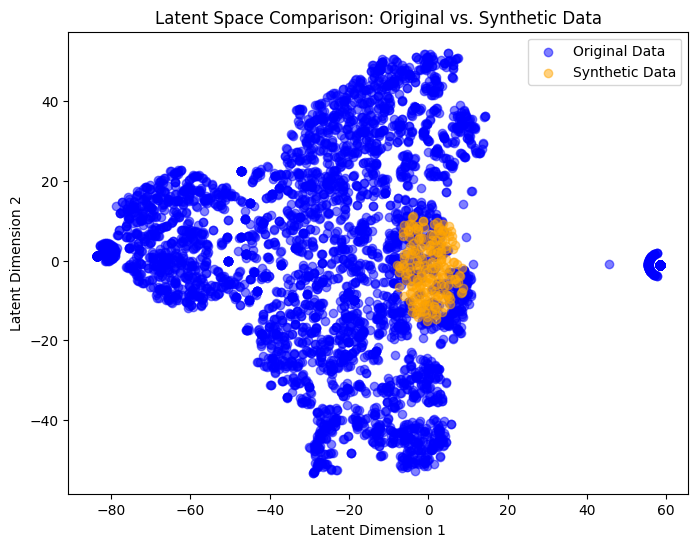

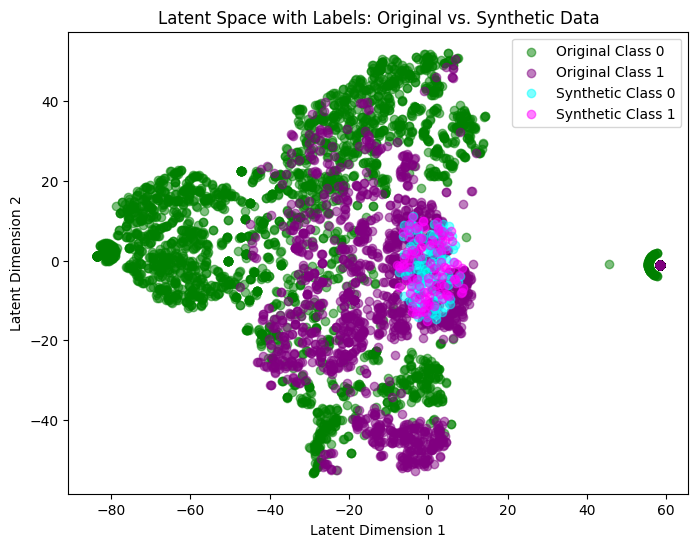

Synthetic data with predictions saved to 'synthetic_data_with_predictions.csv'.
Latent space comparison and classification completed. Synthetic data predictions are saved.


In [15]:
import matplotlib.pyplot as plt

# Step 1: Apply VAE to original data to get latent space
vae.eval()
with torch.no_grad():
    original_reconstructed, original_mu, original_logvar = vae(torch.tensor(processed_data, dtype=torch.float32))

# Step 2: Visualize Latent Space for Original and Synthetic Data
original_latent_2d = TSNE(n_components=2, random_state=42).fit_transform(original_mu.numpy())
synthetic_latent_2d = TSNE(n_components=2, random_state=42).fit_transform(mu.numpy())

# Combine both for visualization
plt.figure(figsize=(8, 6))
plt.scatter(original_latent_2d[:, 0], original_latent_2d[:, 1], label="Original Data", alpha=0.5, color="blue")
plt.scatter(synthetic_latent_2d[:, 0], synthetic_latent_2d[:, 1], label="Synthetic Data", alpha=0.5, color="orange")
plt.title("Latent Space Comparison: Original vs. Synthetic Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

# Step 3: Analyze Clusters in Latent Space (if labels exist)
# For demonstration, generate synthetic labels for original and synthetic data
original_labels = np.array([0] * (original_mu.size(0) // 2) + [1] * (original_mu.size(0) - original_mu.size(0) // 2))
synthetic_labels = np.array([0] * (mu.size(0) // 2) + [1] * (mu.size(0) - mu.size(0) // 2))

# Combine labels with their respective latent spaces for visualization
plt.figure(figsize=(8, 6))
plt.scatter(original_latent_2d[original_labels == 0, 0], original_latent_2d[original_labels == 0, 1],
            label="Original Class 0", alpha=0.5, color="green")
plt.scatter(original_latent_2d[original_labels == 1, 0], original_latent_2d[original_labels == 1, 1],
            label="Original Class 1", alpha=0.5, color="purple")
plt.scatter(synthetic_latent_2d[synthetic_labels == 0, 0], synthetic_latent_2d[synthetic_labels == 0, 1],
            label="Synthetic Class 0", alpha=0.5, color="cyan")
plt.scatter(synthetic_latent_2d[synthetic_labels == 1, 0], synthetic_latent_2d[synthetic_labels == 1, 1],
            label="Synthetic Class 1", alpha=0.5, color="magenta")
plt.title("Latent Space with Labels: Original vs. Synthetic Data")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend()
plt.show()

# Step 4: Use Classifier on Synthetic Data
synthetic_predictions = clf.predict(mu.numpy())

# Save results for synthetic data with predictions
synthetic_results_with_predictions = pd.DataFrame(synthetic_data, columns=[f"Feature_{i+1}" for i in range(synthetic_data.shape[1])])
synthetic_results_with_predictions["Prediction"] = synthetic_predictions
synthetic_results_with_predictions.to_csv("synthetic_data_with_predictions.csv", index=False)

print("Synthetic data with predictions saved to 'synthetic_data_with_predictions.csv'.")

# Analyze classifier performance (if true labels exist, compare with predictions)
print("Latent space comparison and classification completed. Synthetic data predictions are saved.")
